In [236]:


import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from pathlib import Path
import matplotlib.patches as mpatches

sys.path.append('../../../')

from src.emotion.prediction.aggregates.train import HyperparaSearch
from src.emotion.prediction.aggregates.models import MODELS
from src.emotion.prediction.aggregates.test import load_models, generate_predictions, plot_predictions
from src.emotion.utils.constants import DATA_DIR

%matplotlib inline
plt.style.use('ggplot')

# set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#77b5e5', '#e46c81', '#97d2c5', '#e696cc', '#b6b6b6', '#a980b8', '#e9d66b'])

In [237]:
features = pd.read_csv('/home/moritz/Workspace/masterthesis/data/features_dataset_small.csv')

In [238]:
targets = pd.read_csv('/home/moritz/Workspace/masterthesis/data/perma_scores_dataset.csv')

In [239]:
df = pd.merge(features, targets, on=["E-Mail-Adresse", "Day"])

df.shape

(104, 135)

In [240]:
# Handle Missing Values

df.dropna(axis=1, how='any', inplace=True)
#df = dataset.loc[:, (df != 0).any(axis=0)]

print(df.shape)


(104, 132)


In [241]:
# Detect outliers

# Check if all PERMA values are the same in each row
same_PERMA = (df['P'] == df['E']) & (df['E'] == df['R']) & (df['R'] == df['M']) & (df['M'] == df['A'])
# Remove the rows where all PERMA values are the same
df = df[~same_PERMA]
print(df.shape)

# find columns where all values are the same
cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
# drop the columns
df = df.drop(cols_to_drop, axis=1)
print(df.shape)

# drop columns where all values are only 0 or 1
df = df.loc[:, ~(df.isin([0, 1]).all() & ~df.isin([0, 1]).any())]
print(df.shape)

(104, 132)
(104, 132)
(104, 132)


In [242]:
# Load X and Y
# Store the PERMA values in Y
Y = df[['P', 'E', 'R', 'M', 'A']]

# Store the other columns in X
X = df.drop(columns=['ClassID', 'E-Mail-Adresse', 'Day', 'First Name', 'Last Name/Surname', 'P', 'E', 'R', 'M', 'A'])

In [243]:
# Scale Features
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the dataframe and transform the dataframe
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [244]:
X.shape

(104, 122)

In [245]:
corr_matrix = X.corr()

In [246]:
def plot_correlation_matrix(matrix):
    # center the matrix
    matrix = matrix - np.mean(matrix, axis=0)

    # transpose the matrix
    matrix_t = matrix.T

    # compute the correlation matrix using np.corrcoef
    corr_matrix = np.corrcoef(matrix_t)

    # create a heatmap of the correlation matrix using seaborn
    sns.set(font_scale=0.7)
    sns.heatmap(corr_matrix, cmap="YlGnBu")

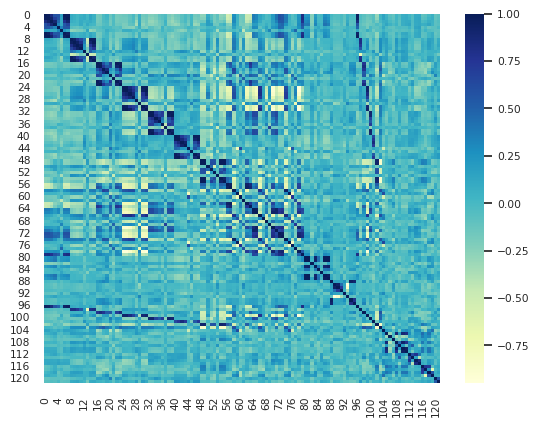

In [247]:
plot_correlation_matrix(X)

In [248]:
def get_selected_voting_features_uni(Y, X_filtered, filter_methods, k):
    feature_counts = np.zeros(X_filtered.shape[1])
        
    for method_name, method in filter_methods.items():
        pipeline = Pipeline([(method_name, method), ('regressor', LinearRegression())])
        pipeline.fit(X_filtered, Y)
        selected_i = pipeline.named_steps[method_name].get_support(indices=True)
        
        # Increment the count for each selected feature
        for index in selected_i:
            feature_counts[index] += 1
                
    # Get the indices of the top k features with the most counts
    top_k_features = np.argsort(feature_counts)[-k:]
    
    return top_k_features

In [249]:
# Create a dictionary for each PERMA pillar
perma_dict = {
    "P": None,
    "E": None,
    "R": None,
    "M": None,
    "A": None,
}

filter_methods = {
    'f_regression': SelectKBest(f_regression, k=10),
    'mutual_info_regression': SelectKBest(mutual_info_regression, k=10),
    'variance_threshold': VarianceThreshold(threshold=0.1),
}

# Iterate over each PERMA dimension in Y
for i, perma_dim in enumerate(Y.columns):
    # Get the selected features for the current PERMA dimension
    selected_features = get_selected_voting_features_uni(Y.iloc[:, i], X, filter_methods, k=10)
    # Save the selected features in the corresponding dictionary for the current PERMA pillar
    perma_dict[perma_dim] = selected_features

# Print the selected features for each PERMA dimension in each PERMA pillar
for pillar in perma_dict:
    print(pillar, ":", perma_dict[pillar])


P : [ 89  87  85  83  78  81  66  26 117  31]
E : [ 22  51  86  85  84  83  81  63  87 110]
R : [94 92 88 33 22 31 25 10 87 85]
M : [ 24 104  64  65  75  91  73  70  19  31]
A : [101  30  82  84  25  24  90  92  80   0]


In [250]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [251]:
feature_sets = {
    "P": {"train": None, "test": None},
    "E": {"train": None, "test": None},
    "R": {"train": None, "test": None},
    "M": {"train": None, "test": None},
    "A": {"train": None, "test": None}
}

for perma_dim, selected_features in perma_dict.items():
    # Select the corresponding columns of X_filtered
    X_train_final = X_train.iloc[:, list(set(selected_features))]
    X_test_final = X_test.iloc[:, list(set(selected_features))]
    # Add the selected features for the current PERMA dimension to the feature sets dictionary
    feature_sets[perma_dim]["train"] = X_train_final
    feature_sets[perma_dim]["test"] = X_test_final
    # Print the names of the selected features
    column_names = X_train_final.columns.tolist()
    print(perma_dim, ":", column_names)


P : ['Arousal__standard_deviation', 'Dominance__P_25', 'Brightness__mean', 'Brightness__maximum', 'Brightness__Slope', 'MutualGaze_Min', 'Brightness__P_75', 'Velocity__mean', 'Sad__standard_deviation', 'Sad__P_75']
E : ['Gazes_Max', 'Brightness__mean', 'Neutral__maximum', 'Brightness__minimum', 'Brightness__Slope', 'Brightness__P_25', 'Happy__P_25', 'Brightness__maximum', 'Brightness__P_75', 'Valence__P_75']
R : ['Surprise__mean', 'Disgust__standard_deviation', 'Brightness__Slope', 'Happy__P_25', 'Brightness__P_75', 'Velocity__median', 'Sad__mean', 'Velocity__minimum', 'Velocity__P_25', 'Sad__P_75']
M : ['Arousal__median', 'Arousal__mean', 'Arousal__P_25', 'Presence', 'Dominance__mean', 'Dominance__maximum', 'Happy__maximum', 'Sad__median', 'Velocity__maximum', 'Sad__P_75']
A : ['Angry__median', 'Fear__max_count', 'Brightness__median', 'Brightness__standard_deviation', 'Brightness__minimum', 'Sad__median', 'Sad__mean', 'Velocity__standard_deviation', 'Velocity__minimum', 'Sad__P_25']


In [252]:
SAVE_DIR = Path("/home/moritz/Workspace/masterthesis/model/custom_models/univariate/small")

eval_metric = "mean_absolute_error"

In [253]:
models_to_drop = ["MLPRegressor", "KNeighborsRegressor", "DecisionTreeRegressor", "SVR"]

for name in models_to_drop:
    for i in range(len(MODELS)):
        if MODELS[i]["name"] == name:
            del MODELS[i]
            break
        
for model in MODELS:
    print(model["name"])

RandomForestRegressor
ExtraTreesRegressor
GradientBoostingRegressor
AdaBoostRegressor
LinearRegression
Ridge
Lasso
ElasticNet
BayesianRidge
CatBoostRegressor
XGBRegressor


In [254]:
results_dict = {}

for perma_dim, X_final in feature_sets.items():
    print(f"PERMA dimension: {perma_dim}")
    # Run the hyperparameter search
    models_path = SAVE_DIR / perma_dim
    search = HyperparaSearch(models=MODELS, metrics=["mean_absolute_error"], models_path = models_path, n_folds=5, n_jobs=-1, mode="uni")
    results = search.run(X_final["train"], Y_train[perma_dim], save=True)
    results_dict[perma_dim] = results
    # Print the model with the lowest score
    best_model = min(
        [
            min(
                sublist,
                key=lambda x: x["score"]
                if x["metric"] == eval_metric
                else float("inf"),
            )
            for sublist in results
        ],
        key=lambda x: x["score"],
    )
    print(perma_dim)
    print(f"Best model: {best_model['name']}")
    print(f"Best params: {best_model['params']}")
    print(f"Best Score: {best_model['score']}")

PERMA dimension: P
Models for RandomForestRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/RandomForestRegressor.joblib
Models for ExtraTreesRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/ExtraTreesRegressor.joblib
Models for GradientBoostingRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/GradientBoostingRegressor.joblib
Models for AdaBoostRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/AdaBoostRegressor.joblib
Models for LinearRegression saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/LinearRegression.joblib
Models for Ridge saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/Ridge.joblib
Models for Lasso saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/Lasso.joblib
Models for ElasticNet saved to /home/

In [255]:
perma_models = {}

for perma_dim in ["P", "E", "R", "M", "A"]:
    models_path = SAVE_DIR / perma_dim
    models = load_models(models_path)
    perma_models[perma_dim] = models

In [256]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def generate_predictions(models, X, y):
    # Generate and return a dictionary of mean absolute error (MAE) scores and prediction arrays for each model
    results = {}
    for model_name, mae_grid_search in models.items():
        # Fit the model
        model = mae_grid_search[0].best_estimator_
        # Make predictions
        y_pred = model.predict(X)
        # Calculate mean squared error and mean absolute error
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        results[model_name] = {"mae": mae, "mse": mse, "y_pred": y_pred}
    return results

In [257]:
perma_results = {}

for dim, models in perma_models.items():
    X_test = feature_sets[dim]["test"]
    results = generate_predictions(models, X_test, Y_test[dim])
    perma_results[dim] = results
    # for model_name, result in results.items():
    #     print(f"{dim} - {model_name}: MAE - {result['mae']}, MSE - {result['mse']}")
    

In [258]:
best_results = {}

for dim, results in perma_results.items():
    curr_mae = float("inf")
    for model in results:
        if results[model]["mae"] < curr_mae:
            curr_mae = results[model]["mae"]
            best_results[dim] = {"model": model, "mae": results[model]["mae"], "preds": results[model]["y_pred"]}
            
print(best_results)

{'P': {'model': 'Ridge', 'mae': 0.7246795727833246, 'preds': array([ 0.07133941,  0.51701098,  0.26606336,  0.20764997,  0.61077896,
       -0.6251054 , -0.48989477, -0.27916268,  0.25502796, -0.09374412,
       -0.36155344,  0.13187416,  0.34550876, -0.0605837 , -0.26636473,
        0.2090233 ,  0.13799551, -0.16485935, -0.13353278, -0.28897237,
       -0.07051408])}, 'E': {'model': 'GradientBoostingRegressor', 'mae': 0.7724304767473132, 'preds': array([-0.67082883,  0.31078204,  0.54927467,  0.14428941,  0.24682079,
       -0.79916391,  0.42220857,  0.38824863, -0.5891114 , -0.27331704,
        0.177754  ,  0.15399453,  0.59645861,  0.6551384 , -0.54357504,
        0.09416523,  0.62217223,  0.30093479,  0.10136497, -0.02072903,
        0.62766224])}, 'R': {'model': 'AdaBoostRegressor', 'mae': 0.7619957038044464, 'preds': array([-0.00841979,  0.26445362,  0.25612521,  0.0485376 ,  0.45416316,
       -0.2913018 ,  0.21839007, -1.37911172,  0.47775371,  0.1192278 ,
        0.14462224, -

In [259]:
best_feats_dict = {}

for dim, results in results_dict.items():
    best_feats_dict[dim] = {model[0]['name']: {"feat_imp": model[0]['best_feats'], "score": model[0]["score"]}  for model in results}

best_feats_dict_dim = {}
    
for dim in ['P', 'E', 'R', 'M', 'A']:
    model = best_results[dim]["model"]
    feat_imp = abs(best_feats_dict[dim][model]["feat_imp"])
    best_feats_dict_dim[dim] = feat_imp

best_feats_dict_dim


{'P': array([0.18228759, 0.3409353 , 0.03970153, 0.1744544 , 1.01183453,
        0.28728926, 0.12691146, 0.06308309, 0.04684354, 0.05170993]),
 'E': array([0.08526628, 0.05276456, 0.09059747, 0.05257898, 0.02795023,
        0.07663463, 0.12730079, 0.18121107, 0.02578062, 0.27991537]),
 'R': array([0.10216767, 0.08926402, 0.2046966 , 0.07051429, 0.12697599,
        0.16677968, 0.05000511, 0.07622559, 0.0622002 , 0.05117086]),
 'M': array([0.53778497, 0.02603081, 0.0477475 , 0.08347604, 0.82342435,
        0.10772197, 0.5734732 , 0.        , 0.7671199 , 0.21378685]),
 'A': array([0.0756786 , 0.03871062, 0.23450171, 0.0476299 , 0.05632647,
        0.05234007, 0.09224804, 0.10100026, 0.25650982, 0.04505451])}

In [260]:
ranked_feats_dict = {}

for (dim, feat_imp_vals), (dim, X_final) in zip(best_feats_dict_dim.items(), feature_sets.items()):
    # Map the feature importance values with the feature list using a dictionary comprehension
    column_names = X_final["train"].columns.tolist()
    feat_imp_map = {column_names[i]: feat_imp_vals[i] for i in range(len(column_names))}
    # Rank the features by their importance value in descending order
    ranked_feats = sorted(feat_imp_map.items(), key=lambda x: x[1], reverse=True)
    ranked_feats_dict[dim] = ranked_feats


/tmp/ipykernel_156845/4206057206.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')


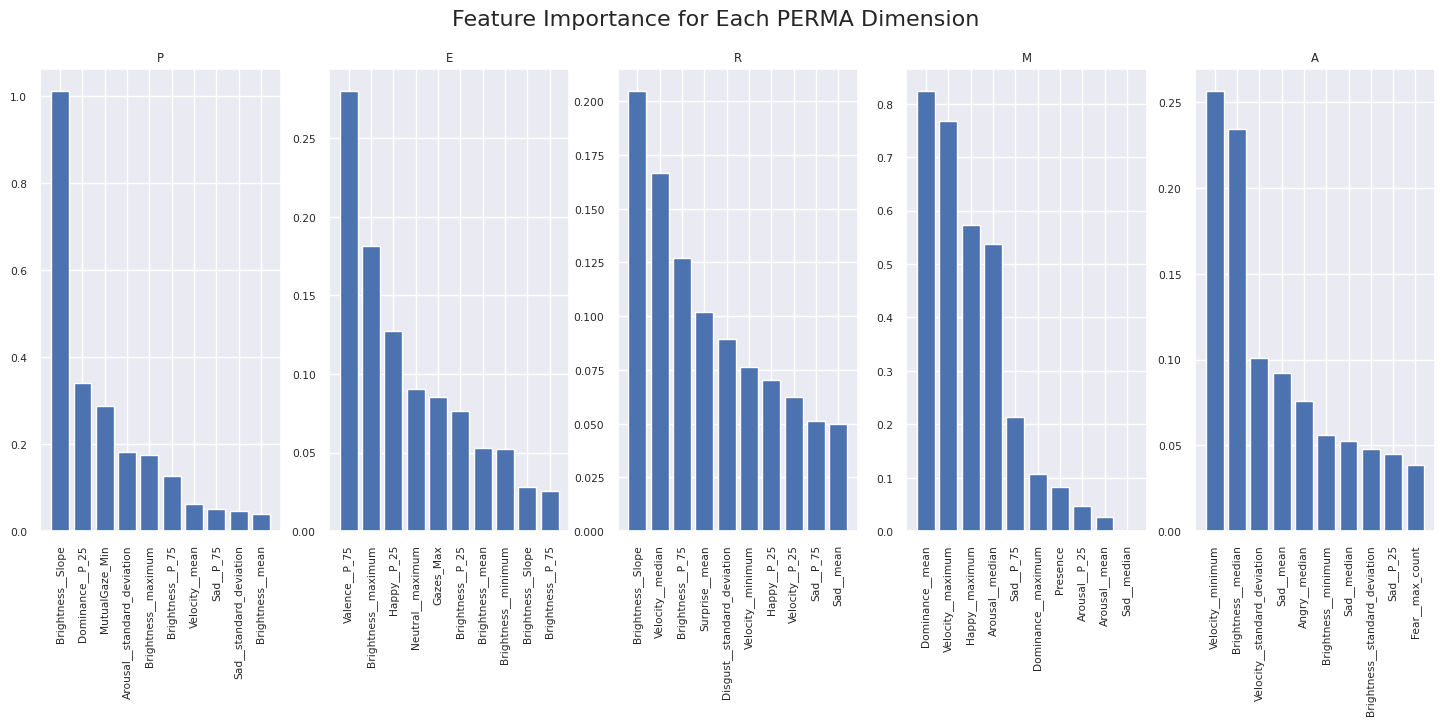

In [266]:
#Separate the feature names and importance scores for each dimension PERMA
P_features, P_scores = zip(*ranked_feats_dict["P"])
E_features, E_scores = zip(*ranked_feats_dict["E"])
R_features, R_scores = zip(*ranked_feats_dict["R"])
M_features, M_scores = zip(*ranked_feats_dict["M"])
A_features, A_scores = zip(*ranked_feats_dict["A"])


#Create a bar plot for each dimension PERMA
fig, axs = plt.subplots(1, 5, figsize=(18, 6))
axs[0].bar(P_features, P_scores)
axs[0].set_title("P")
axs[1].bar(E_features, E_scores)
axs[1].set_title("E")
axs[2].bar(R_features, R_scores)
axs[2].set_title("R")
axs[3].bar(M_features, M_scores)
axs[3].set_title("M")
axs[4].bar(A_features, A_scores)
axs[4].set_title("A")

#Set common axis labels and title
fig.suptitle("Feature Importance for Each PERMA Dimension", fontsize=16)
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')

In [262]:
# Baseline:
Y_baseline = np.full_like(Y_test, Y_test.mean(axis=0).transpose())
mae_baseline = mean_absolute_error(Y_test, Y_baseline, multioutput='raw_values')

print(f"Baseline MAE for each dimension: {mae_baseline}")

Baseline MAE for each dimension: [0.84705643 0.83483656 0.82358261 0.78212217 0.77659055]


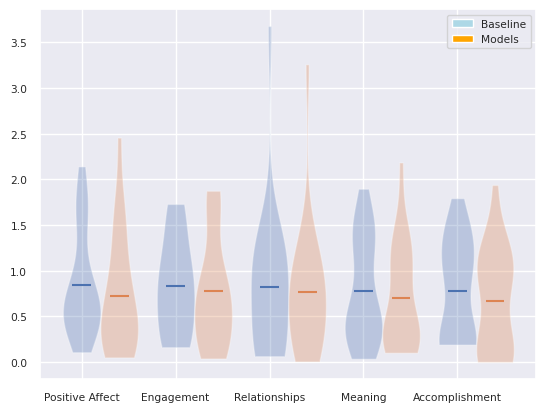

In [263]:
# Calculate the errors between the actual values and the baseline predictions
baseline_errors = abs(Y_test - Y_baseline)

# Calculate the errors for each model and each dimension
model_errors = pd.DataFrame()

# Calculate the errors for each model and each dimension
for dim in ['P', 'E', 'R', 'M', 'A']:
    err = abs(Y_test[dim] - best_results[dim]['preds'])
    errors = pd.DataFrame({'errors': err})
    model_errors = pd.concat([model_errors, errors], axis=1)

# Concatenate baseline and model errors
all_errors = [baseline_errors, model_errors]

# Create a combined boxplot
fig, ax = plt.subplots()
colors = ['lightblue', 'orange']
labels = ['Baseline', 'Models']

for i, error_df in enumerate(all_errors):
    position = np.arange(1, len(error_df.columns) + 1) + (i * 0.4)
    #ax.boxplot(error_df, positions=position, widths=0.4, patch_artist=True, boxprops=dict(facecolor=colors[i]), medianprops=dict(color='black'))
    ax.violinplot(error_df, positions=position, widths=0.4, showmedians=False, showextrema=False, showmeans=True)

# Define the labels for the x-axis
perma = ['Positive Affect', 'Engagement', 'Relationships', 'Meaning', 'Accomplishment']

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(1, len(perma) + 1))
ax.set_xticklabels(perma)

# Create the legend patches and labels
patches = [mpatches.Patch(facecolor=color, label=label) for color, label in zip(colors, labels)]

# Add the legend to the plot
ax.legend(handles=patches, loc='upper right')

Text(0.5, 1.0, 'PERMA Dimension MAE Scores')

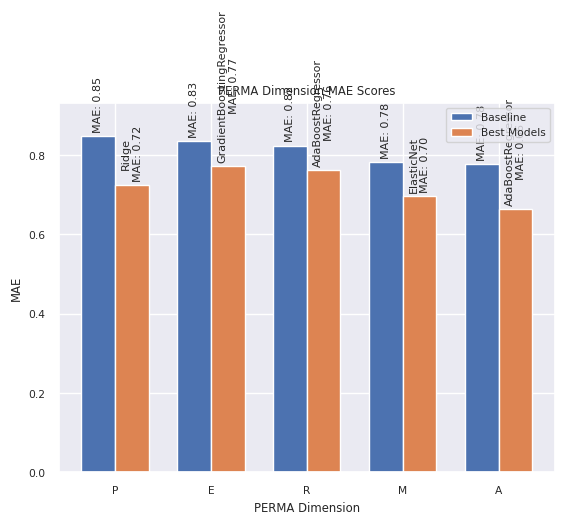

In [264]:
# Print the best model for each PERMA dimension
best_mae_values = [v['mae'] for v in best_results.values()]

# Define the x-axis labels and the bar width
perma_dimensions = ['P', 'E', 'R', 'M', 'A']
bar_width = 0.35

# Set up the plot
fig, ax = plt.subplots()
ax.bar(np.arange(len(perma_dimensions)), mae_baseline, width=bar_width, label='Baseline')
ax.bar(np.arange(len(perma_dimensions))+bar_width, best_mae_values, width=bar_width, label='Best Models')

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(len(perma_dimensions))+bar_width/2)
ax.set_xticklabels(perma_dimensions)
ax.set_xlabel('PERMA Dimension')

# Set the y-axis label and limits
ax.set_ylabel('MAE')
ax.set_ylim([0, max(np.max(mae_baseline), np.max(best_mae_values))*1.1])

# Add the model names and MAE values above each bar
for i, v in enumerate(mae_baseline):
    ax.text(i, v+0.01, f"MAE: {v:.2f}", rotation=90, ha='center', va='bottom', fontsize=8)
    ax.text(i+bar_width, best_mae_values[i]+0.01, f"{best_results[perma_dimensions[i]]['model']}\nMAE: {best_mae_values[i]:.2f}", rotation=90, ha='center', va='bottom', fontsize=8)

# Add a legend and title
ax.legend()
ax.set_title('PERMA Dimension MAE Scores')

Text(0.5, 1.0, 'PERMA')

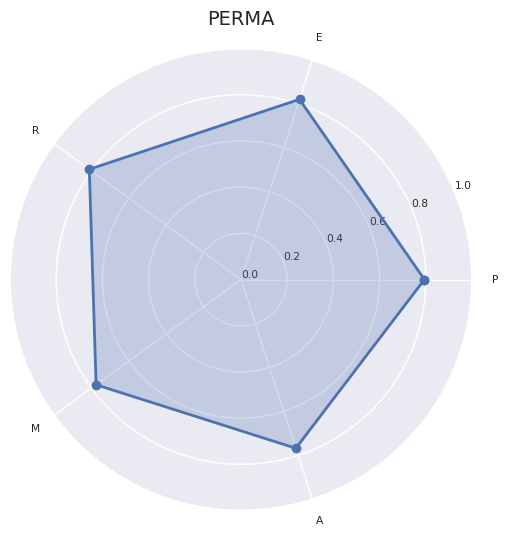

In [265]:
labels = ['P', 'E', 'R', 'M', 'A']
data = np.array([0.79393424, 0.82001125, 0.81170323, 0.77526397, 0.76808988])

# Calculate the angle for each label
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

# Close the plot
data = np.concatenate((data, [data[0]]))
angles = np.concatenate((angles, [angles[0]]))

# Create the figure
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

# Plot the data
ax.plot(angles, data, 'o-', linewidth=2)
ax.fill(angles, data, alpha=0.25)

# Set the labels
ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylim(0, 1)
plt.title('PERMA', fontsize=14)